In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from lens import ray
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

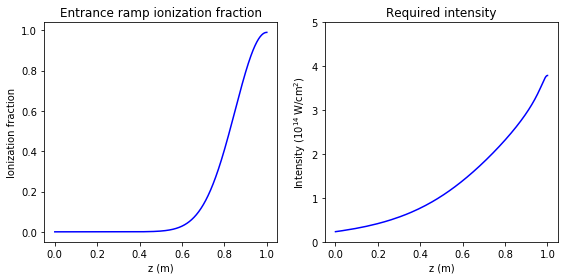

In [2]:
# The 0.375 is the frequency of the pulse in 1/fs
# this corresponds to lambda=0.8um
def f(I, t):
    return ionization.gaussian_field(I, t, .375, 50).real

I = np.arange(0, 10, .005)
t = np.arange(-100, 100, 0.1)

# Diatomic hydrogen
g = adk.intensity_func(15.426, I, t, f, 1)

# Desired density curve
d2 = 1.0
sigma = 0.15
z = np.linspace(0, 1, 1000)
n = 0.99*np.exp(-(d2-z)**2/(2*sigma**2))
Iramp = g(n)

# Plot the desired ionization fraction and the required intensity
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(z, n, 'b-')
plt.title('Entrance ramp ionization fraction')
plt.xlabel('z (m)')
plt.ylabel('Ionization fraction')


plt.subplot(122)
plt.plot(z, Iramp, 'b-')
plt.title('Required intensity')
plt.xlabel('z (m)')
plt.ylabel(r'Intensity ($10^{14}\,\mathrm{W/cm}^2$)')
plt.ylim([0,5])

plt.tight_layout()
plt.show()

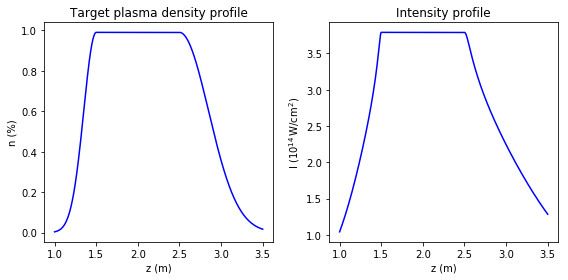

In [31]:
# First test of a tailored plasma profile (ray approximation)
# Temporal pulse shape, assume 50fs duration
def f(I, t):
    return ionization.gaussian_field(I, t, .375, 50).real
I = np.linspace(0, 10, 1000)
t = np.linspace(-100, 100, 1000)
# Diatomic hydrogen - intensity from ionization fraction
g = adk.intensity_func(15.426, I, t, f, 1)

# Create the z grid
NEnt = 500
NBody = 1000
NExit = 1000
Nz = NEnt + NBody + NExit
d1 = 1e6
d2 = 1.5e6
d3 = 2.5e6
d4 = 3.5e6
zEnt = np.linspace(d1, d2, NEnt, False)
zBody = np.linspace(d2, d3, NBody, False)
zExit = np.linspace(d3, d4, NExit)
z = np.concatenate((zEnt, zBody, zExit))

# Entrance and exit ramps
sigmaEnt = 150e3
sigmaExit = 350e3
nEnt = 0.99*np.exp(-(zEnt-d2)**2/(2*sigmaEnt**2))
nBody = np.zeros(NBody) + 0.99
nExit = 0.99*np.exp(-(zExit-d3)**2/(2*sigmaExit**2))
n = np.concatenate((nEnt, nBody, nExit))

# Calculate the desired intensity profile
I = g(n)

# Plot initial conditions
plt.figure(figsize=(8,4))
# Ionization fraction
plt.subplot(121)
plt.plot(z/1e6, n, 'b-')
plt.title('Target plasma density profile')
plt.xlabel('z (m)')
plt.ylabel('n (%)')
# Intensity profile
plt.subplot(122)
plt.plot(z/1e6, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')

plt.tight_layout()
plt.show()

0.0229543010118


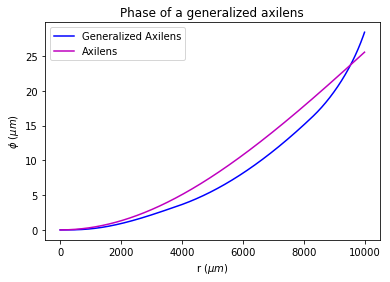

In [62]:
R = 10e3
I0, r, phi = ray.uniform_phase(I, z, R)

f0 = d2
dz = d3-d2
phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2

print(I0)
plt.plot(r, abs(phi*4),'b-',r, abs(phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Generalized Axilens','Axilens'])
plt.show()

In [1]:
# Create an interpolating function for the phase
phir = interp1d(r, phi)
# Initial electric field
def Efunc(x, y):
    # Input flatop beam
    R = params['w0']
    r = np.sqrt(x**2 + y**2)
    E0 = np.zeros(np.shape(r))
    E0[r < R] = 1.0
    # Generalized Axilens
    k = 2*np.pi / params['lam']
    phi = np.zeros(np.shape(r))
    phi[r < R] = abs(params['phi'](r[r < R]))*4
    T0 = np.exp(-1j*k*phi)
    # Initial electric field
    return E0 * T0

# Setup the parameters
params = {'Nx' : 2**10,
          'Ny' : 2**10,
          'Nz' : 2**8,
          'X' : R*3,
          'Y' : R*3,
          'Z' : d4-d1,
          'z0' : d1,
          'E0' : ionization.field_from_intensity(I0),
          'lam' : 0.8,
          'n' : 1.0,
          # Params for the E-field function
          'w0' : R,
          'phi' : phir
          }

path = '/media/robert/Data_Storage/Data/Optics/Axilens/'

directory = 'Generalized_Axilens_Test1'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

NameError: name 'interp1d' is not defined

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/numpy/lib/function_base.py:3771: RuntimeWarning: invalid value encountered in sin
  return sin(y)/y


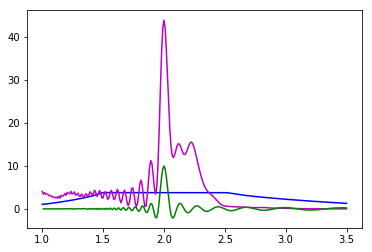

In [102]:
Eplot = np.load(params['path']+'electricField.npy')
Iaxis = ionization.intensity_from_field(abs(Eplot[:, int(params['Nx']/2), int(params['Ny']/2)]))

zsim = np.linspace(params['z0'], params['z0']+params['Z'], params['Nz'])
sinc = 10*np.sinc((zsim-2e6)/(4.75e4*(zsim-1e6)/1e6))

plt.plot(z/1e6, I, 'b', zsim/1e6, Iaxis/5, 'm-', zsim/1e6, sinc, 'g-')
plt.show()
del Eplot